In [21]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS

In [22]:
Suppl = Chem.SDMolSupplier('80-selected-cqr-conf.sdf')

In [23]:
uni = []
uni_Stru = []

for x in Suppl:
    if x is not None:
        Name = x.GetProp('_Name')
        if Name not in uni:
            uni.append(Name)
            uni_Stru.append(x)

In [38]:
Mol_S = [x for x in uni_Stru]

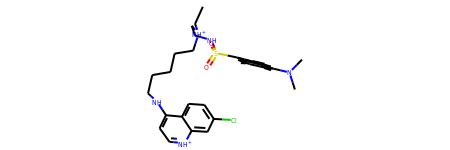

In [39]:
Mol_S[0]

In [40]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m in Mol_S]

# How many compounds/fingerprints do we have?
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 79
Fingerprint length per compound: 2048


In [41]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix


In [42]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [43]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.2)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  22
# clusters with only 1 compound:  8
# clusters with >5 compounds:  3
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


Number of clusters 22 from 79 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 23
Similarity between two random points in same cluster 0.96
Similarity between two random points in different cluster 0.76


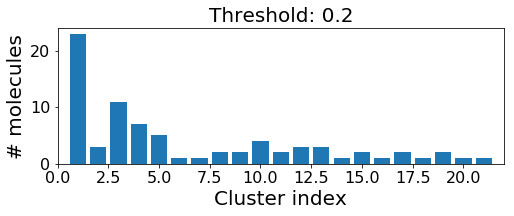

In [44]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(Mol_S), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

Ten molecules from largest cluster:


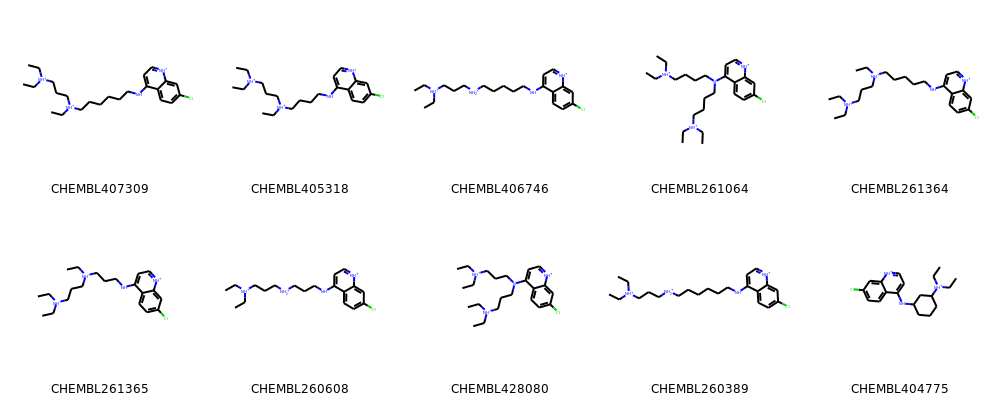

In [47]:
print ('Ten molecules from largest cluster:')
# Draw molecules

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(Mol_S[i])) for i in clusters[0][:10]] , legends=[Mol_S[i].GetProp('_Name') for i in clusters[0][:10]], molsPerRow=5)

All clusters Representatives:


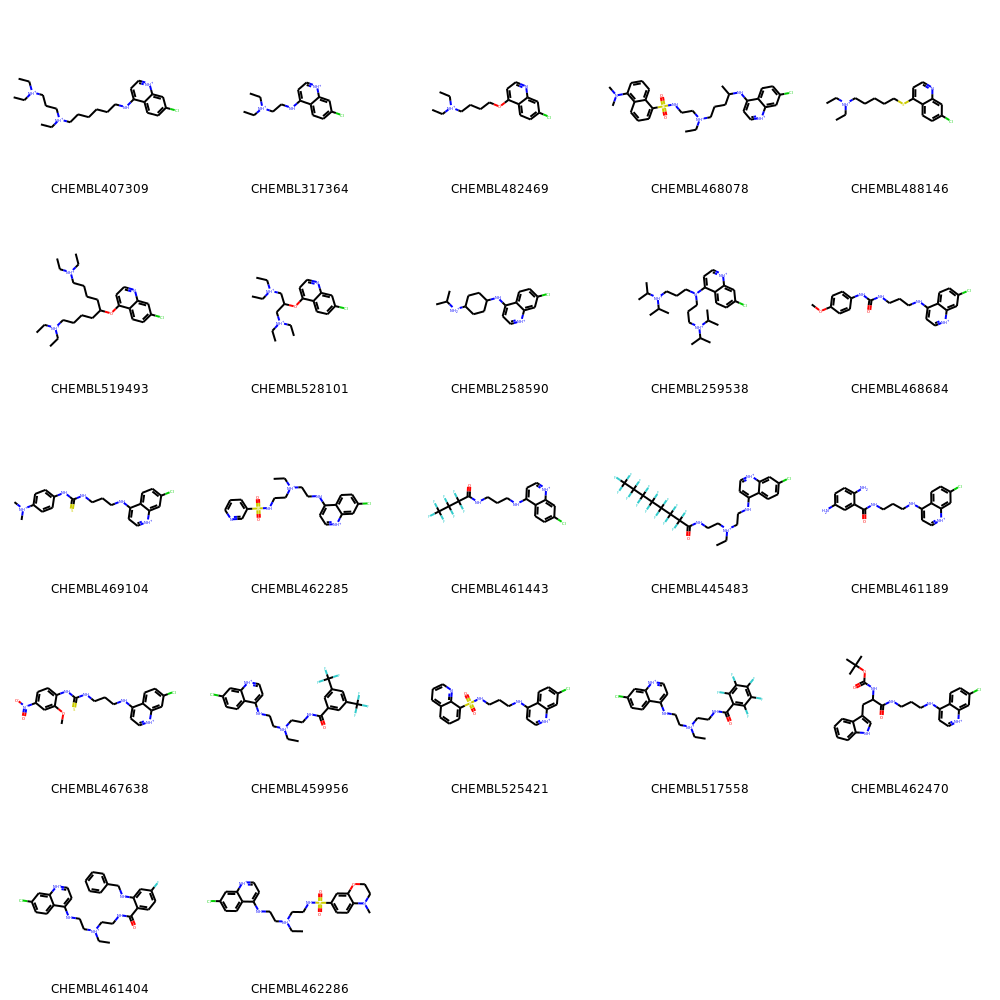

In [55]:
print ('All clusters Representatives:')
# Draw molecules
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(Mol_S[clusters[i][0]])) for i in range(0,22)],legends=[Mol_S[clusters[i][0]].GetProp('_Name') for i in range(0,22)],molsPerRow=5)

#img.save('../Phase-CQS/cluster/cluster-60-66-Rep.png')

In [56]:
#Write cluster members in file
def clusterMember(Number):
    filename = 'cluster-'+str(Number)+'.sdf'
    w = Chem.SDWriter(filename)
    dd = list(clusters[Number])
    print(dd)
    for x in dd:
        Name = Mol_S[x].GetProp('_Name')
        print(Name)
        w.write(Mol_S[x])

In [58]:
for s in range(0,22):
    clusterMember(s)

[44, 32, 34, 35, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 61, 68, 76]
CHEMBL407309
CHEMBL405318
CHEMBL406746
CHEMBL261064
CHEMBL261364
CHEMBL261365
CHEMBL260608
CHEMBL428080
CHEMBL260389
CHEMBL404775
CHEMBL427732
CHEMBL259983
CHEMBL596502
CHEMBL593748
CHEMBL593261
CHEMBL596500
CHEMBL596077
CHEMBL594435
CHEMBL260474
CHEMBL596076
CHEMBL259641
CHEMBL147802
CHEMBL144037
[62, 55, 75]
CHEMBL317364
CHEMBL593525
CHEMBL448846
[70, 54, 56, 57, 59, 60, 65, 66, 67, 73, 74]
CHEMBL482469
CHEMBL593737
CHEMBL595862
CHEMBL595829
CHEMBL593492
CHEMBL595602
CHEMBL216926
CHEMBL443725
CHEMBL519636
CHEMBL484296
CHEMBL482470
[30, 0, 8, 14, 19, 25, 26]
CHEMBL468078
CHEMBL468278
CHEMBL468279
CHEMBL466196
CHEMBL466403
CHEMBL466197
CHEMBL467006
[78, 64, 69, 71, 77]
CHEMBL488146
CHEMBL488145
CHEMBL502643
CHEMBL341638
CHEMBL488359
[72]
CHEMBL519493
[63]
CHEMBL528101
[42, 31]
CHEMBL258590
CHEMBL406124
[36, 33]
CHEMBL259538
CHEMBL260852
[27, 7, 10, 23]
CHEMBL468684
CHEMBL447072
CHEMBL447508
CHE